In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
import numpy as np
import pandas as pd
import awkward as ak
from numba import njit
import vector
vector.register_numba()
vector.register_awkward()
import torch

from pprint import pprint 
hep.style.use(hep.style.ROOT)

import hist
import plot_loss
from torch import optim
from tqdm.notebook import trange

from sklearn.preprocessing import StandardScaler

# Prepare the dataset

In [2]:
#df = ak.from_parquet("/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_v6.parquet")
df = ak.from_parquet("all_jets_v6.parquet")

In [3]:
(jets,
partons_matched,
partons,
generator_info,
lepton_partons,
lepton_reco, 
met
) = ak.unzip(df)

jets = ak.with_name(jets, name="Momentum4D")
partons_matched = ak.with_name(partons_matched, name="Momentum4D")
partons = ak.with_name(partons, name="Momentum4D")
lepton_partons = ak.with_name(lepton_partons, name="Momentum4D")
lepton_reco = ak.with_name(lepton_reco, name="Momentum4D")
met = ak.with_name(met, name="Momentum4D")

In [4]:
@njit
def sum_vectors_all(arrays):
    size = len(arrays)
    results = np.zeros((size, 4))
    for i, array in enumerate(arrays):
        total = vector.obj(px=0.0, py=0.0, pz=0.0, E=0.0)
        for v in array:
            total = total + v
        results[i, 0] = total.px
        results[i, 1] = total.py
        results[i, 2] = total.pz
        results[i, 3] = total.E
    return results


def get_vector_sum(vectors):
    out = sum_vectors_all(vectors)
    return vector.awk({
        "px": out[:, 0],
        "py": out[:, 1],
        "pz": out[:, 2],
        "E": out[:, 3],
    })

In [5]:
boost_jets = get_vector_sum(jets)
boost_reco = boost_jets + lepton_reco + met

initial_pz = 6500*(generator_info.x1 - generator_info.x2)
initial_E = 6500*(generator_info.x1 + generator_info.x2)

initial_boost = ak.Array(
    {"px": np.zeros_like(initial_pz), "py": np.zeros_like(initial_pz), "pz": initial_pz, "E": initial_E},
    with_name="Momentum4D"
)

## Convert the dataset to torch

In [6]:
y_cond = np.stack( [ 
    ak.to_numpy(boost_reco.pz, allow_missing=None),
    ak.to_numpy(boost_reco.E, allow_missing=None)]).T

y_cond

array([[ 557.26771986,  707.36037147],
       [1952.8069725 , 2215.60626402],
       [-432.7080822 ,  684.2705409 ],
       ...,
       [-647.29124928, 1052.08657337],
       [-503.69562626,  882.34073397],
       [  -7.0186224 , 1141.42667515]])

In [7]:
# Rescaling
Y_scaled = torch.from_numpy(np.sign(y_cond)*np.log(abs(y_cond))).float()
Y_scaled[:,1] -= 7

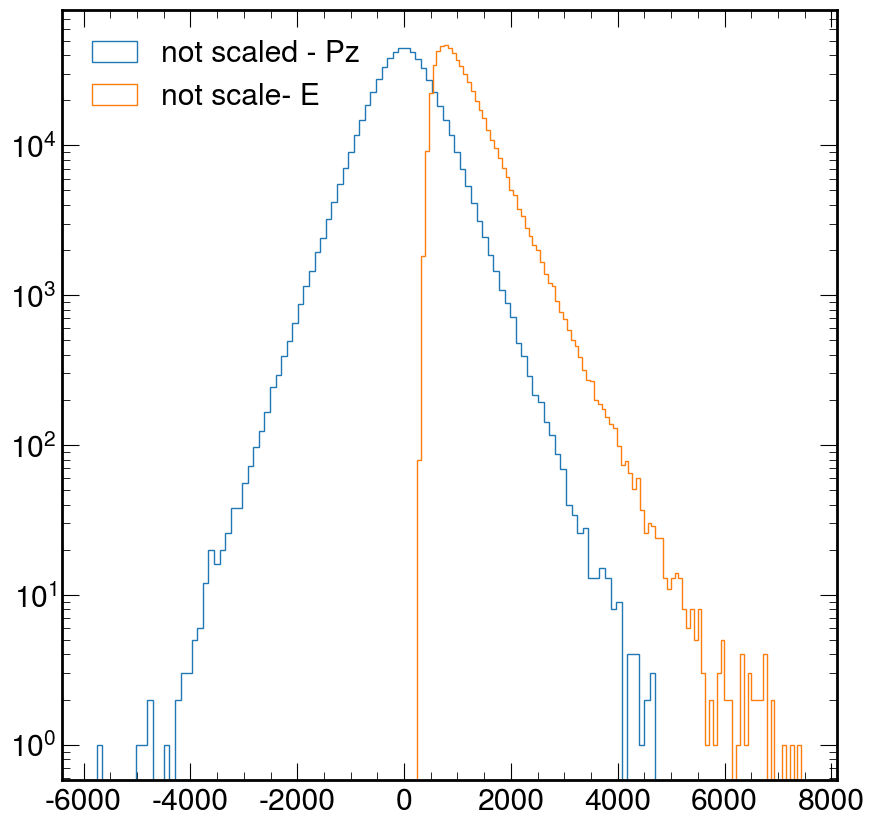

In [8]:
plt.hist(y_cond[:,0], bins=100, histtype="step", label="not scaled - Pz");
plt.hist(y_cond[:,1], bins=100, histtype="step", label="not scale- E");
plt.yscale("log")
plt.legend();

In [9]:
scaler = StandardScaler()

In [10]:
Y_scaled = torch.from_numpy(scaler.fit_transform(y_cond)).float()

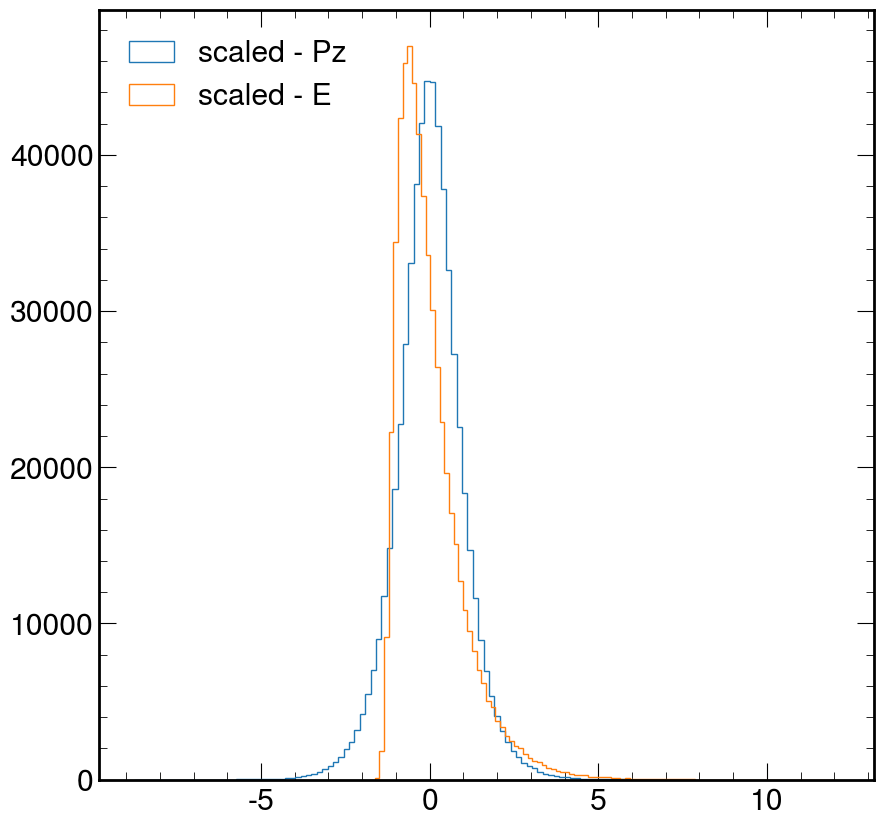

In [11]:
plt.hist(Y_scaled[:,0].numpy(), bins=100, histtype="step", label="scaled - Pz");
plt.hist(Y_scaled[:,1].numpy(), bins=100, histtype="step", label="scaled - E");
#plt.yscale("log")
plt.legend();

In [12]:
x_target = np.stack( [ 
    ak.to_numpy(generator_info.x1, allow_missing=None),
    ak.to_numpy(generator_info.x2, allow_missing=None)]).T

x_target_torch = torch.from_numpy(x_target).float()
# transform it to pz and E
X = torch.zeros_like(x_target_torch)
X[:,0] = 6500*(x_target_torch[:,0]-x_target_torch[:,1])
X[:,1] = 6500*(x_target_torch[:,0]+x_target_torch[:,1])

X_scaled = torch.from_numpy(scaler.transform(X)).float()

Text(0, 1, 'E reco (conditioning)')

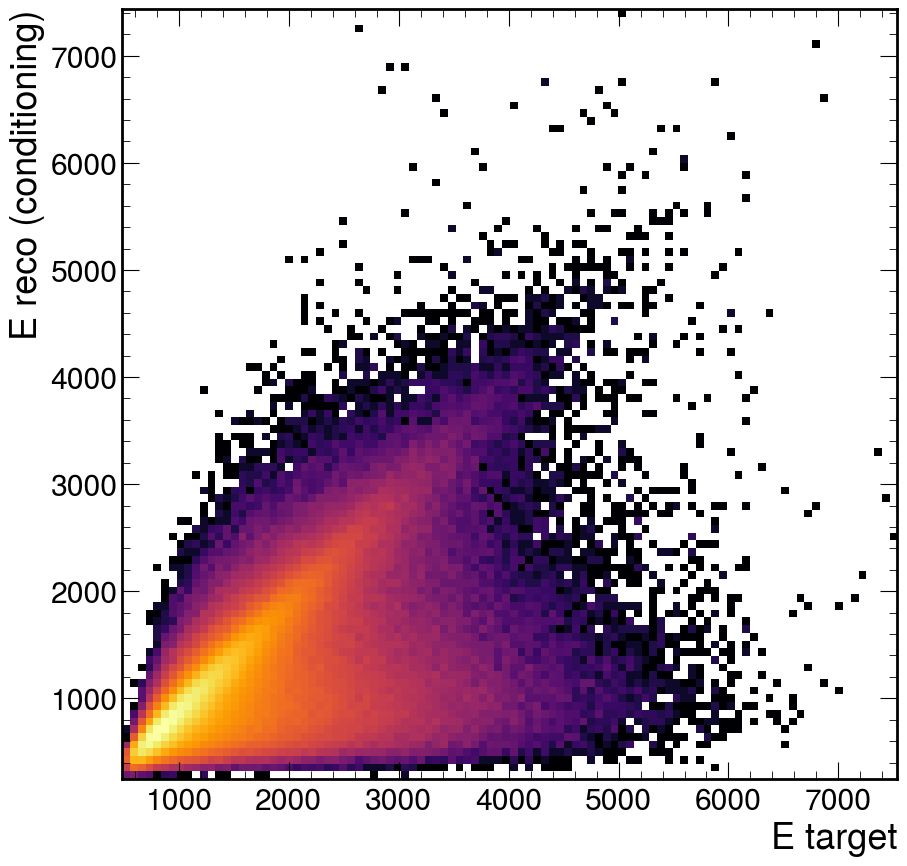

In [13]:
plt.hist2d(X[:,1].numpy(),
           y_cond[:,1],
           bins=[100,100],cmap="inferno", cmin=1, norm=LogNorm());
plt.xlabel("E target")
plt.ylabel("E reco (conditioning)")

Text(0, 1, 'Pz reco (conditioning)')

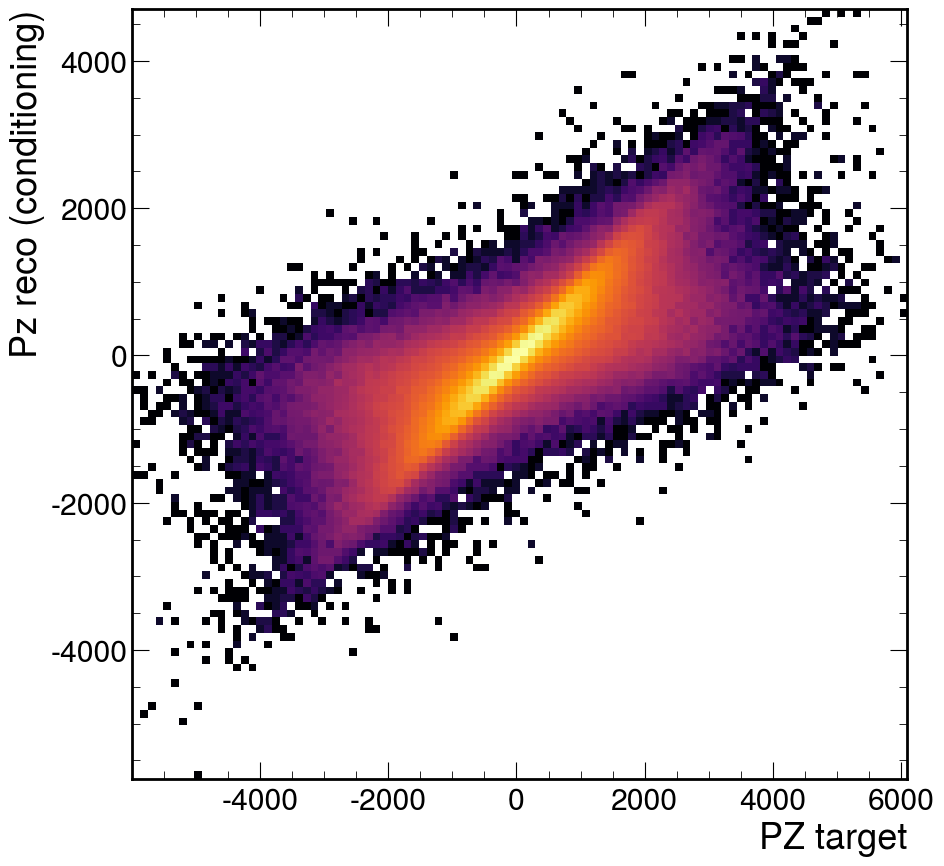

In [14]:
plt.hist2d(X[:,0].numpy(),
           y_cond[:,0],
           bins=[100,100],cmap="inferno", cmin=1, norm=LogNorm());
plt.xlabel("PZ target")
plt.ylabel("Pz reco (conditioning)")

Text(0, 1, 'Pz reco (conditioning) - scaled')

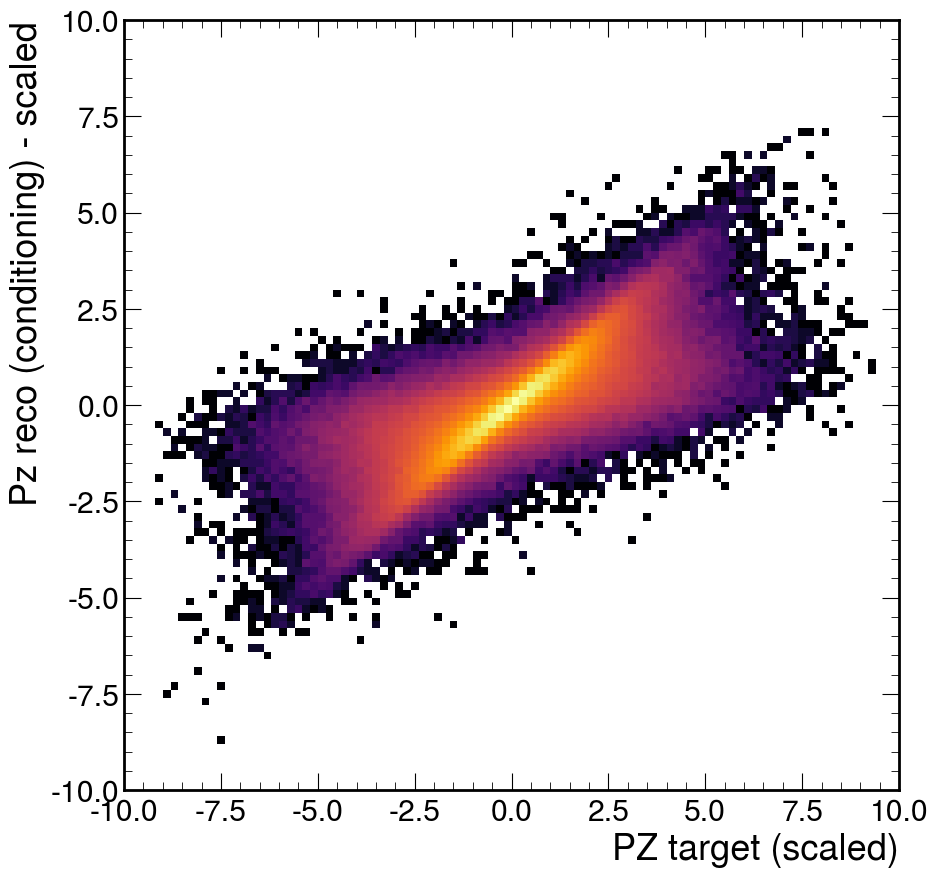

In [15]:
plt.hist2d(X_scaled[:,0].numpy(),
           Y_scaled[:,0].numpy(),
           bins=[100,100],
           range=[[-10,10],[-10,10]], cmap="inferno", cmin=1, norm=LogNorm());
plt.xlabel("PZ target (scaled)")
plt.ylabel("Pz reco (conditioning) - scaled")

Text(0, 1, 'E reco (conditioning) - scaled')

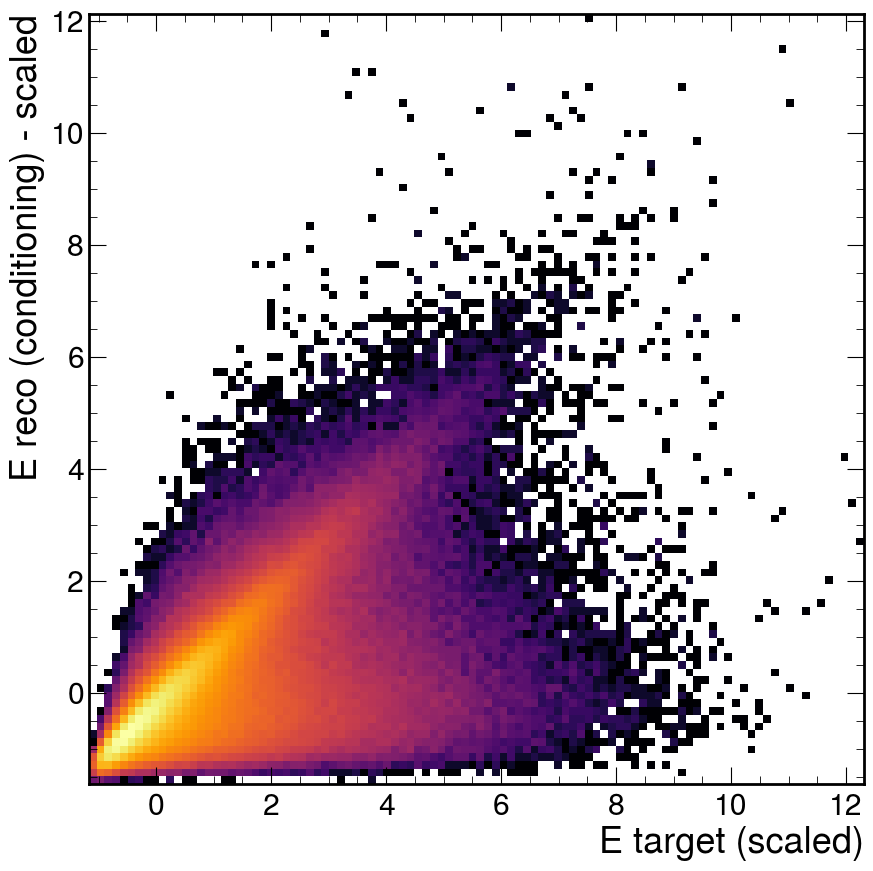

In [16]:
plt.hist2d(X_scaled[:,1].numpy(),
           Y_scaled[:,1].numpy(),
           bins=[100,100], cmap="inferno", cmin=1, norm=LogNorm());
plt.xlabel("E target (scaled)")
plt.ylabel("E reco (conditioning) - scaled")

# Define the flow

In [17]:
import zuko
from zuko.flows import TransformModule, SimpleAffineTransform
from zuko.distributions import BoxUniform, DiagNormal

In [12]:
flow = zuko.flows.MAF(2, context=2, transforms=6, hidden_features=[32, 32], 
                      randperm=True,
                      base=DiagNormal)

In [18]:
def build_flow(features, ntransforms=4, context=None, hidden_mlp=[32]*3, bins=8, autoregressive=True):
    flow = zuko.flows.NSF(features, context=context, transforms=ntransforms, bins=bins, hidden_features=hidden_mlp, 
                      randperm=True,
                      base=BoxUniform,
                      base_args=[torch.ones(features)*(-1),torch.ones(features)],
                      univariate_kwargs={"bound": 1 }, # Keeping the flow in the [-1,1] box.
                      passes= 2 if not autoregressive else features)

    flow.transforms.insert(0, SimpleAffineTransform(0*torch.ones(features),1*torch.ones(features),
                                                 -1*torch.ones(features), 1*torch.ones(features)))
    
    return flow

In [19]:
def build_flow_gauss(features, ntransforms=4, context=None, hidden_mlp=[32]*3, bins=8, autoregressive=True):
    flow = zuko.flows.NSF(features, context=context, transforms=ntransforms, bins=bins, hidden_features=hidden_mlp, 
                      randperm=True,
                      base=DiagNormal,
                      univariate_kwargs={"bound": 10},
                      passes= 2 if not autoregressive else features)
    return flow

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
flow = build_flow(features=2, ntransforms=3, context=2, hidden_mlp=[32], bins=8, autoregressive=True)

In [24]:
flow = build_flow_gauss(features=2, ntransforms=4, context=2, hidden_mlp=[32]*2, bins=8, autoregressive=True)

In [17]:
flow

NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [1, 0]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=4, out_features=32, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=32, out_features=46, bias=True)
      )
    )
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=4, out_features=32, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=32, out_features=46, bias=True)
      )
    )
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=4, out_

In [21]:
Y_scaled

tensor([[ 6.3230, -0.4385],
        [ 7.5770,  0.7033],
        [-6.0701, -0.4716],
        ...,
        [-6.4728, -0.0415],
        [-6.2220, -0.2174],
        [-1.9486,  0.0400]])

In [65]:
y_cond_scaled.shape

torch.Size([584143, 2])

In [25]:
out = flow(Y_scaled[0:10000]).sample((1, )).squeeze(0)
out.shape

torch.Size([10000, 2])

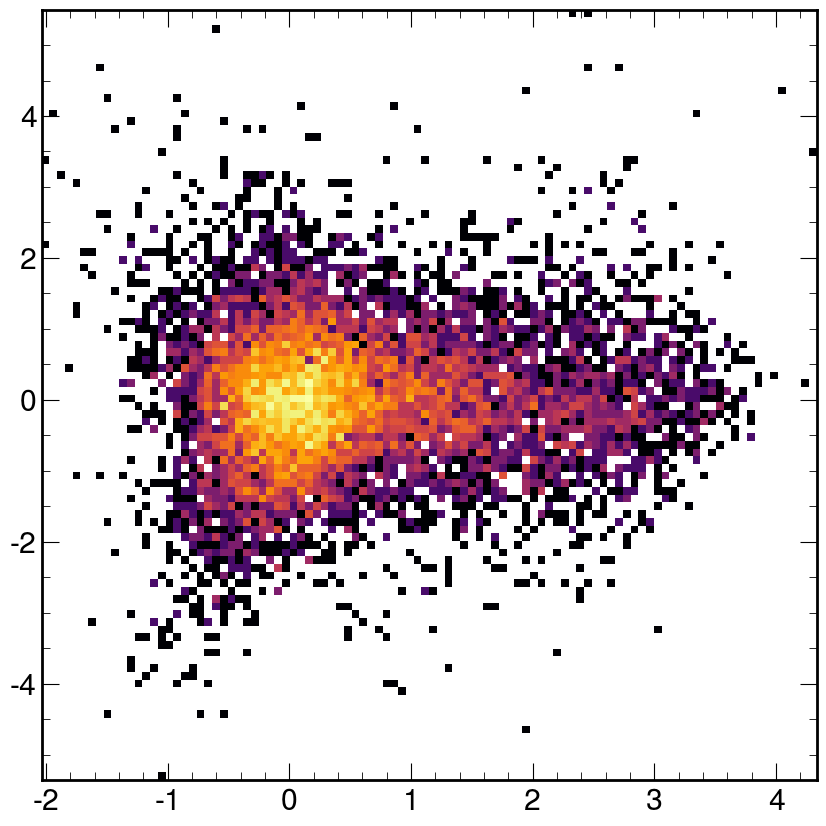

In [26]:
plt.hist2d( out[:,0].numpy(), 
           Y_scaled[0:10000,0].numpy(), 
          bins=100,cmap="inferno", cmin=1, norm=LogNorm() );

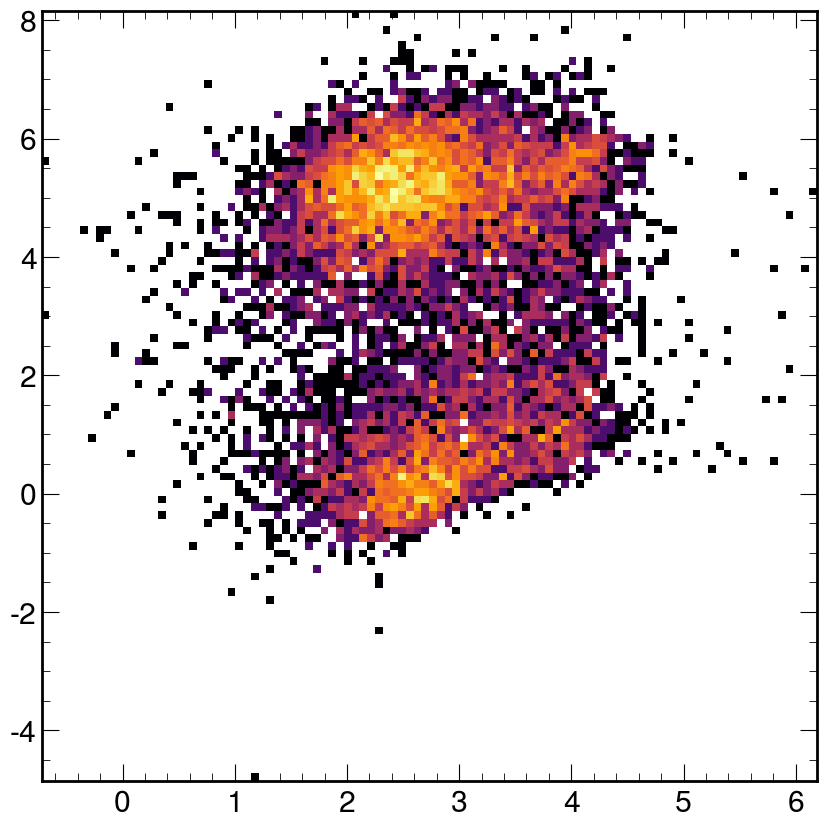

In [22]:
plt.hist2d(out[:,0].numpy(), out[:,1].numpy(),
           bins=100, cmap="inferno", cmin=1, norm=LogNorm());

# Training loop

In [198]:
nepochs = 50
batch_size = 1024
lr_init = 0.0001
N_training_samples = len(Y_scaled)

In [207]:
flow = build_flow_gauss(features=2, ntransforms=3, context=2, hidden_mlp=[32,32], bins=15, autoregressive=True)
optimizer = optim.Adam(flow.parameters(), lr=lr_init)

#decay = 0.01
#fcn = lambda step: 1./(1. + decay*step)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=fcn)

plotter = plot_loss.LossPlotter(["loss"])

print(count_parameters(flow))

12360


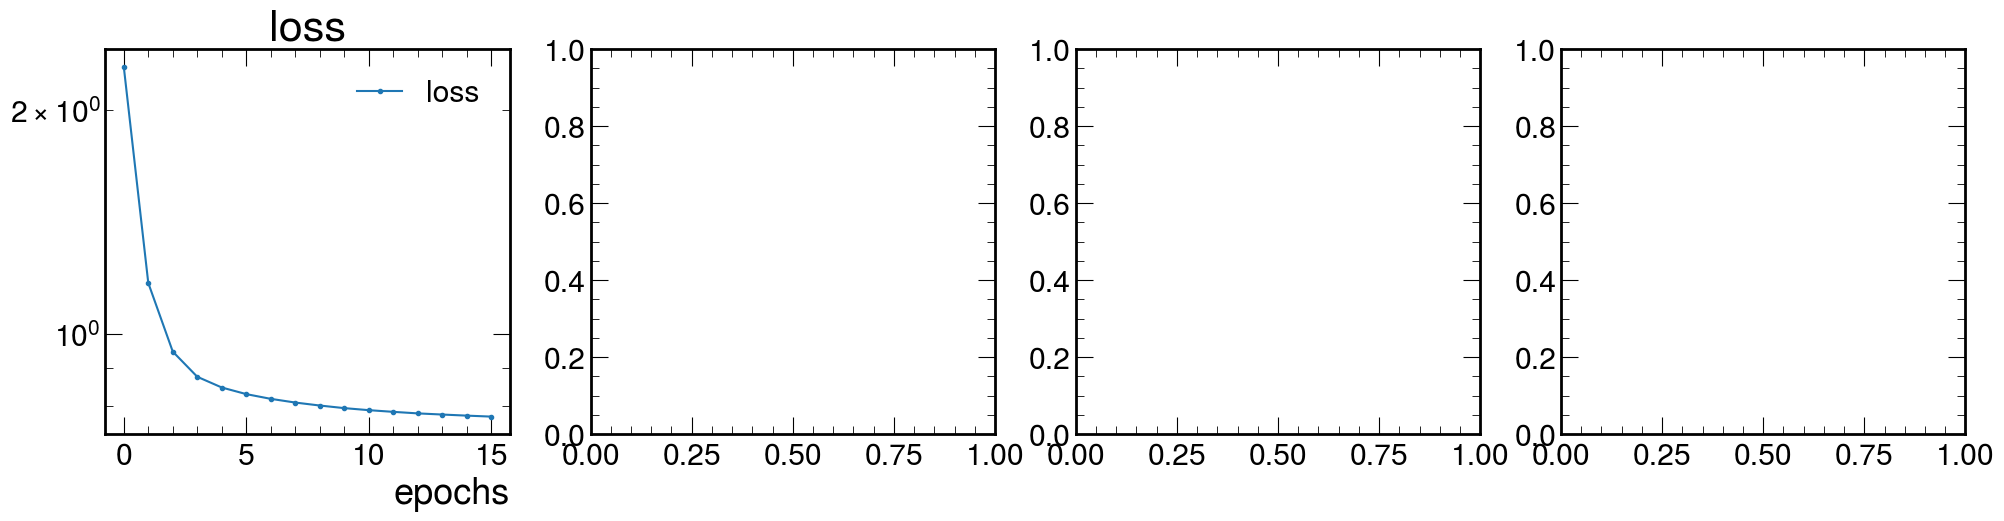

Batch:   0%|          | 0/571 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [208]:
for e in trange(0, nepochs, desc="Epoch"):
    
    permutation = torch.randperm(N_training_samples)
    t = trange(0, N_training_samples, batch_size, desc="Batch")
    
    sum_loss = 0.
    N = 0
    for i in t:
        N  +=1
            
        indices = permutation[i:i+batch_size]
        
        # Computing the reversed KL divergence loss
        optimizer.zero_grad()

        # Adding log(detRambo^-1) = - log(detRambo) to the jacobian
        logp_g =  flow(Y_scaled[indices]).log_prob(X_scaled[indices])

        loss =  - logp_g.mean()
        loss.backward()

        optimizer.step()     
        sum_loss += loss.item()

        #plotter.on_epoch_end({"loss": loss.item()})
#         if i % (batch_size *20) == 0:
#             t.set_description(f"{loss.item():.4f}", refresh=True)
    plotter.on_epoch_end({"loss":sum_loss/N})
        
    
#     with torch.no_grad():
#         out = flow(Y_scaled[0:30000]).sample((1, )).squeeze(0)
#         plt.hist2d(out[:,0].numpy(), 
#                    Y_scaled[0:30000,0].numpy(), 
#                    bins=100,cmap="inferno", cmin=1, norm=LogNorm() );
#         plt.xlabel("Pz generated")
#         plt.ylabel("Pz reco (conditioning)")
        
#         # plt.hist2d(out[:,0].numpy(), out[:,1].numpy(),
#         #    bins=100, cmap="inferno", cmin=1, norm=LogNorm());
        
#         plt.show()
#         plt.close()


In [209]:
out = flow(Y_scaled).sample((1, )).squeeze(0)
out.shape


torch.Size([584143, 2])

Text(0, 1, 'E - target')

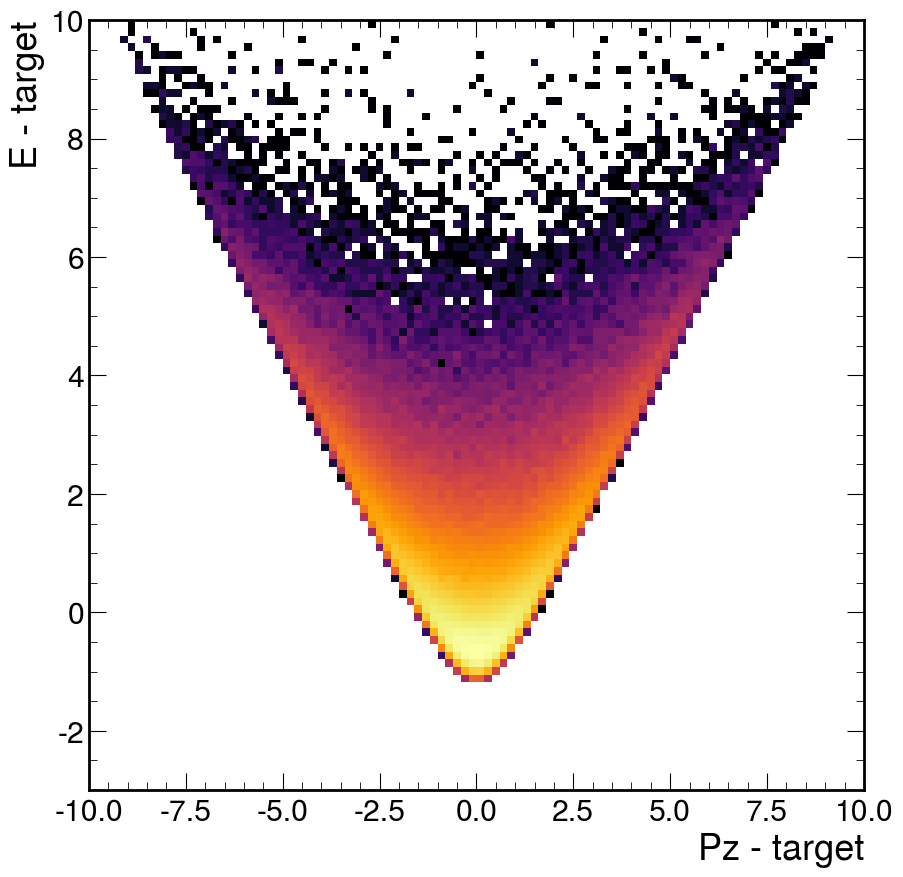

In [210]:
plt.hist2d(X_scaled[:,0].numpy(), 
           X_scaled[:,1].numpy(), 
          bins=100,range=[[-10,10],[-3,10]],
           cmap="inferno", cmin=1, norm=LogNorm() );
plt.xlabel("Pz - target")
plt.ylabel("E - target")

Text(0, 1, 'E - generated')

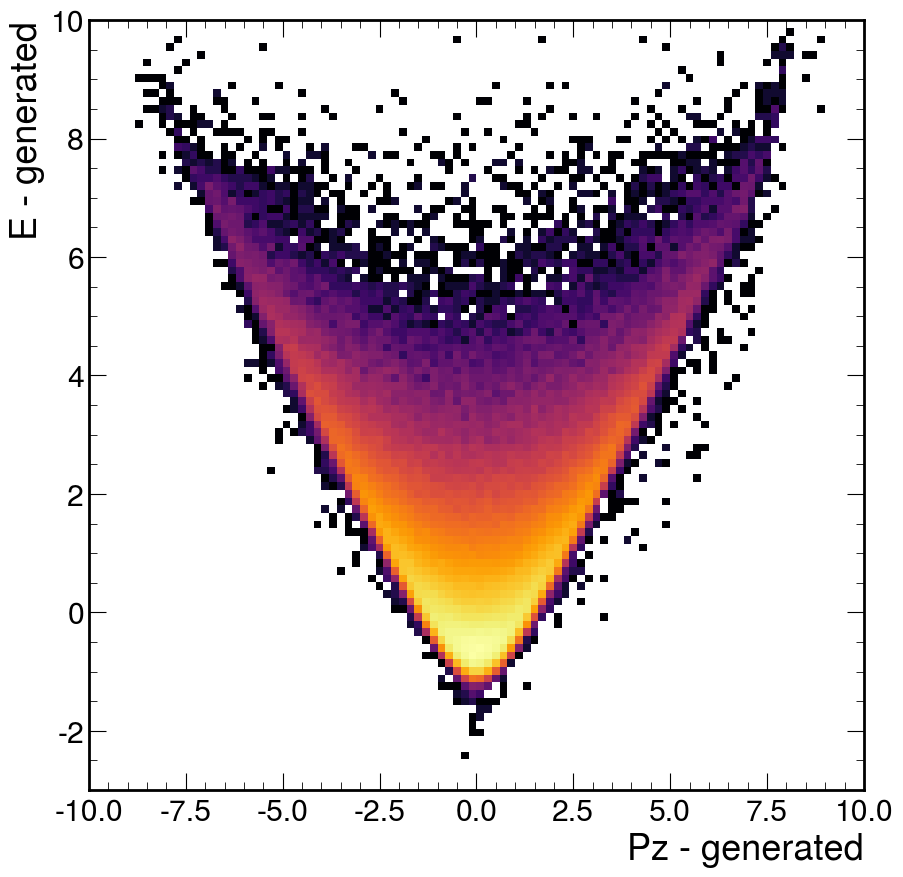

In [211]:
plt.hist2d(out[:,0].numpy(), 
           out[:,1].numpy(), 
          bins=100,range=[[-10,10],[-3,10]],
           cmap="inferno", cmin=1, norm=LogNorm() );
plt.xlabel("Pz - generated")
plt.ylabel("E - generated")

Text(0, 1, 'E reco')

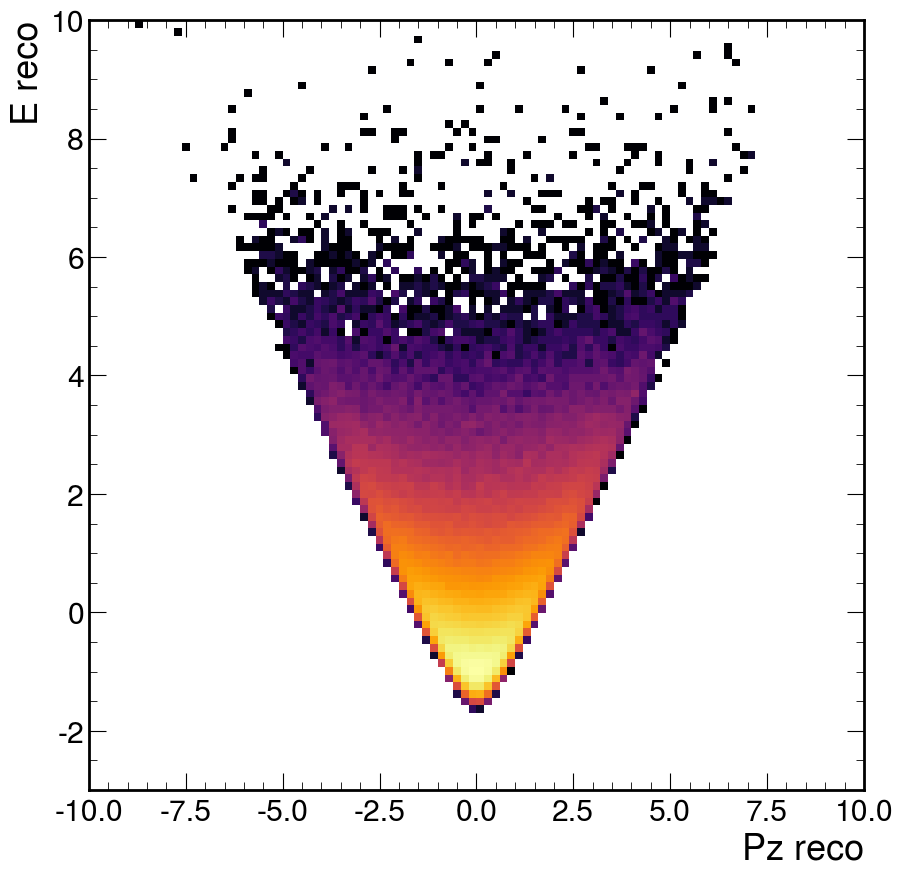

In [212]:
plt.hist2d(Y_scaled[:,0].numpy(), 
           Y_scaled[:,1].numpy(), 
          bins=100,range=[[-10,10],[-3,10]],
           cmap="inferno", cmin=1, norm=LogNorm() );
plt.xlabel("Pz reco")
plt.ylabel("E reco")

Text(0, 1, 'E reco')

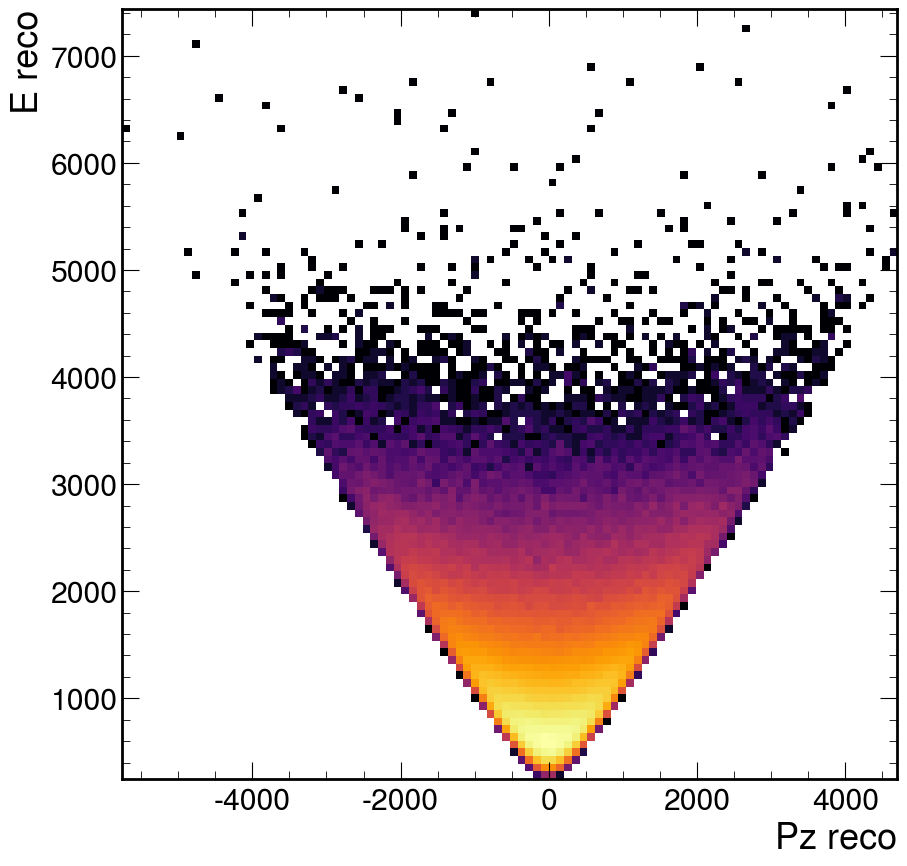

In [158]:
plt.hist2d(y_cond[:,0], 
           y_cond[:,1], 
          bins=100,
           cmap="inferno", cmin=1, norm=LogNorm() );
plt.xlabel("Pz reco")
plt.ylabel("E reco")

Text(0, 1, 'Pz reco (conditioning)')

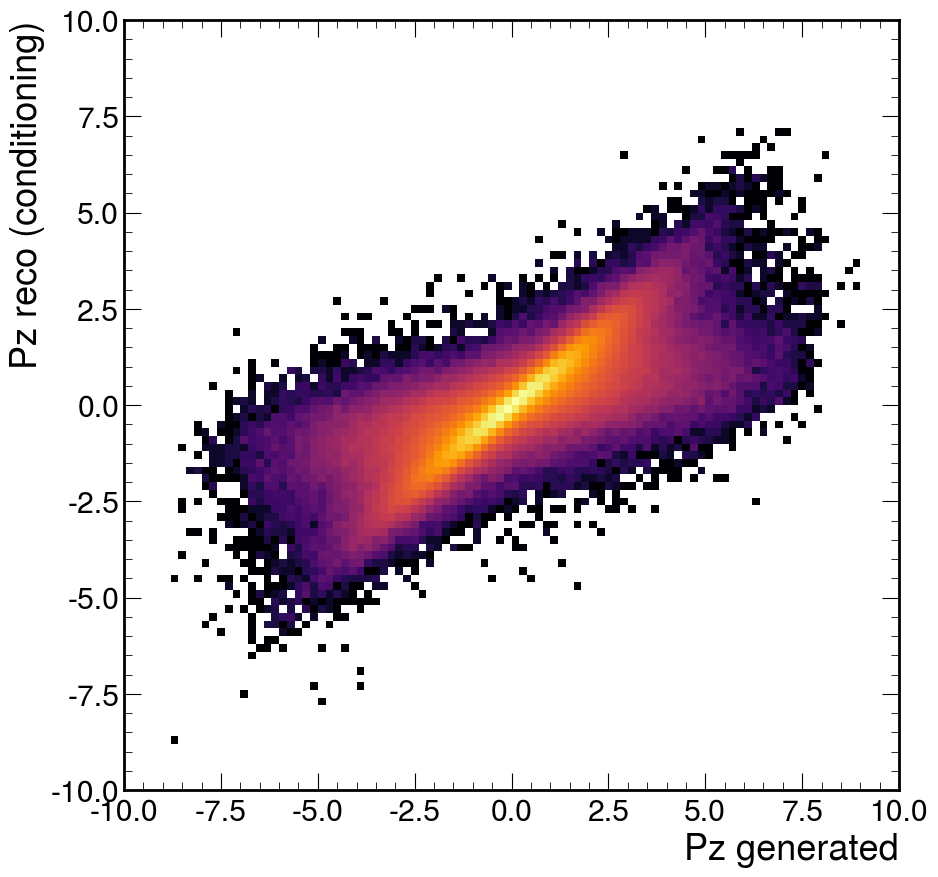

In [213]:
plt.hist2d(out[:,0].numpy(), 
           Y_scaled[:,0].numpy(), 
          bins=100,range=[[-10,10],[-10,10]],
           cmap="inferno", cmin=1, norm=LogNorm() );
plt.xlabel("Pz generated")
plt.ylabel("Pz reco (conditioning)")

Text(0, 1, 'Pz reco (conditioning) - scaled')

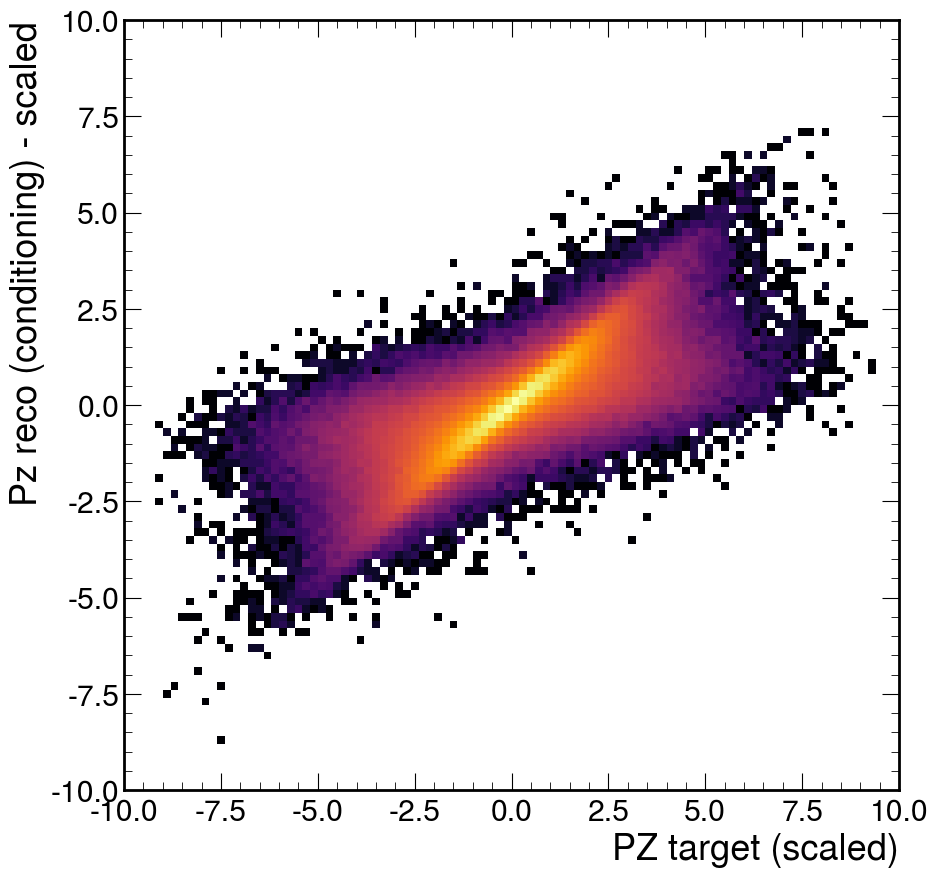

In [44]:
plt.hist2d(X_scaled[:,0].numpy(),
           Y_scaled[:,0].numpy(),
           bins=[100,100],
           range=[[-10,10],[-10,10]], cmap="inferno", cmin=1, norm=LogNorm());
plt.xlabel("PZ target (scaled)")
plt.ylabel("Pz reco (conditioning) - scaled")

Text(0, 1, 'E reco (conditioning)')

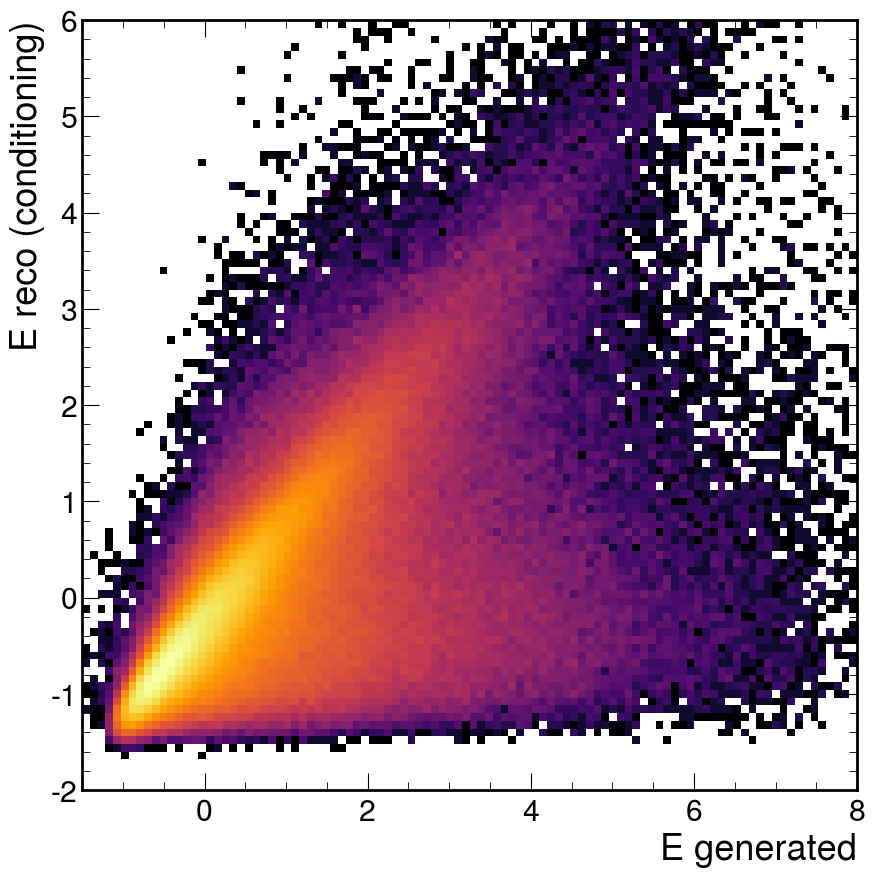

In [214]:
plt.hist2d(out[:,1].numpy(), 
           Y_scaled[:,1].numpy(), 
          bins=100,cmap="inferno", cmin=1, norm=LogNorm(), range=((-1.5,8),(-2,6)) );
plt.xlabel("E generated")
plt.ylabel("E reco (conditioning)")

Text(0, 1, 'E reco (conditioning) - scaled')

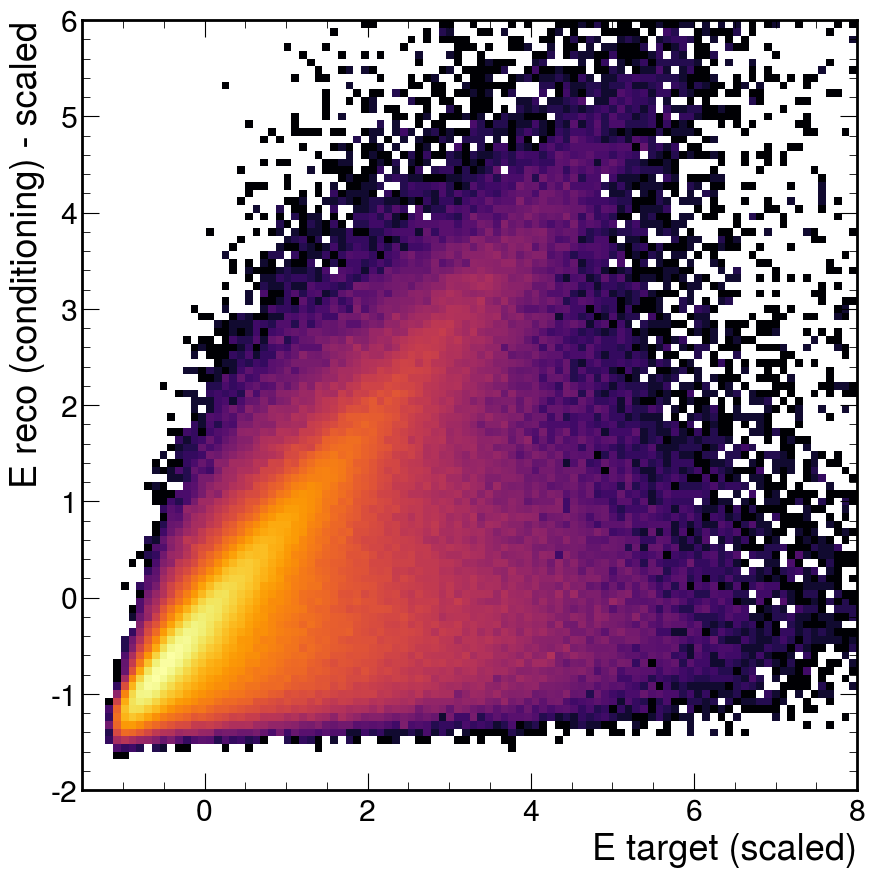

In [215]:
plt.hist2d(X_scaled[:,1].numpy(),
           Y_scaled[:,1].numpy(),
           bins=[100,100], cmap="inferno", cmin=1,range=((-1.5,8),(-2,6)) , norm=LogNorm());
plt.xlabel("E target (scaled)")
plt.ylabel("E reco (conditioning) - scaled")

In [216]:
out_back = scaler.inverse_transform(out)
x1 = (out_back[:,0] + out_back[:,1])/(6500*2)
x2 = out_back[:,1]/6500  - x1

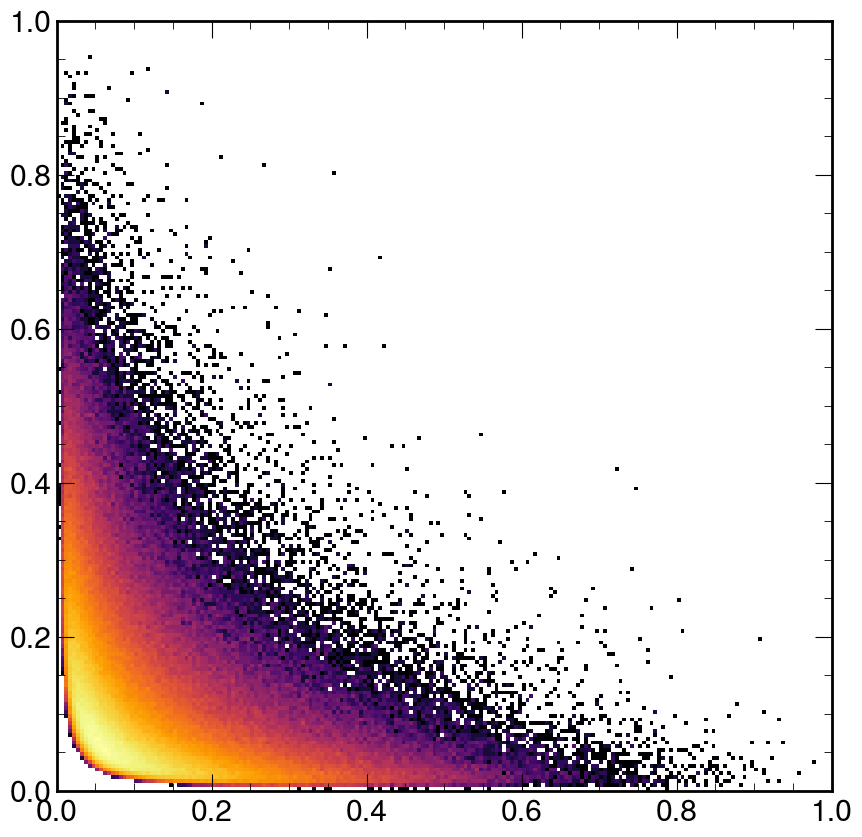

In [217]:
plt.hist2d(ak.to_numpy(generator_info.x1),
           ak.to_numpy(generator_info.x2),
           bins=200, cmap="inferno", cmin=1, norm=LogNorm(), range=((0,1),(0,1)));

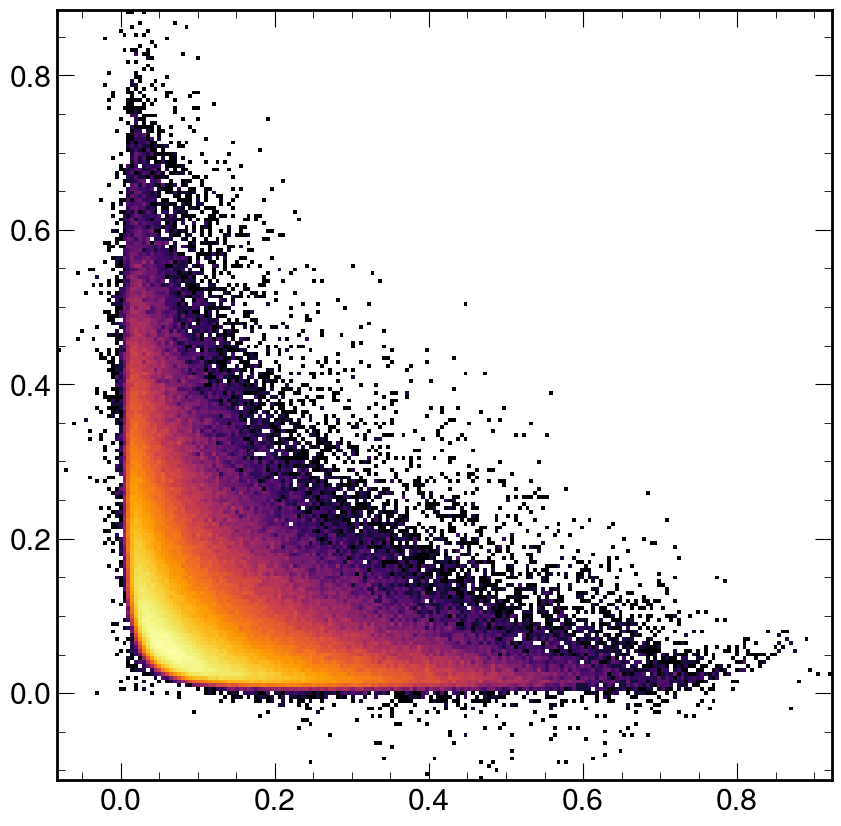

In [218]:
plt.hist2d(x1, x2,
           bins=200, cmap="inferno", cmin=1, norm=LogNorm(), );

In [224]:
z, ladj = flow(Y_scaled[0:20000]).transform.call_and_ladj(X_scaled[0:20000])

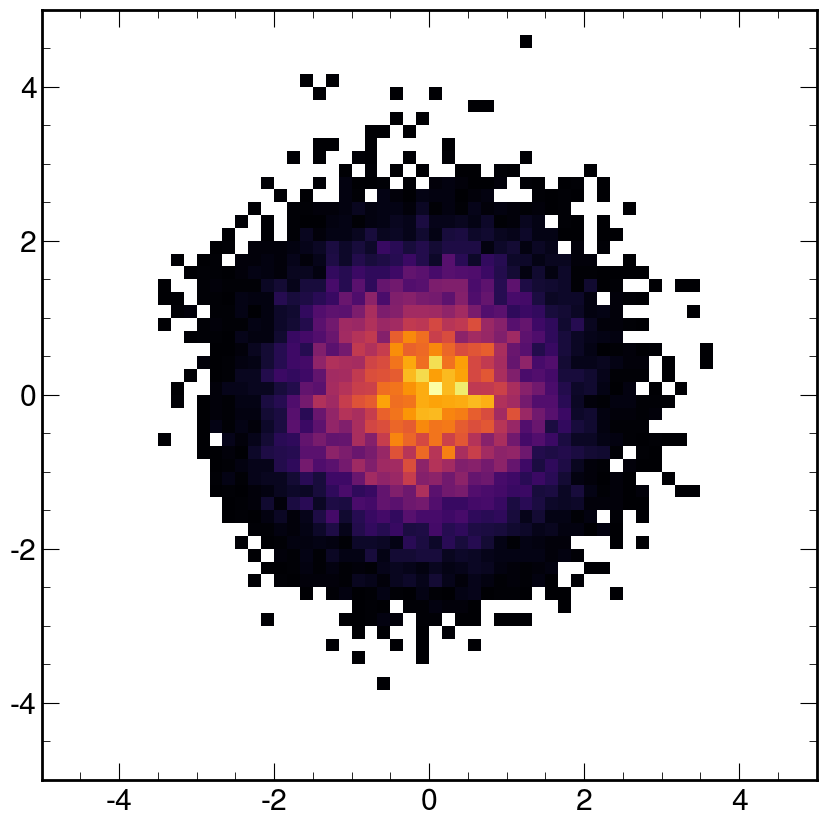

In [227]:
plt.hist2d(z[:,0].detach().numpy(), z[:,1].detach().numpy(), bins=60, cmap="inferno",
          cmin=1, range=((-5,5),(-5,5)));

# Slice analysis

In [71]:
Y_scaled

tensor([[ 0.8569, -0.7462],
        [ 2.9860,  2.1373],
        [-0.6535, -0.7903],
        ...,
        [-0.9809, -0.0871],
        [-0.7618, -0.4117],
        [-0.0041,  0.0837]])

In [278]:
out = flow(torch.tensor([[2,3]])).sample((100000,)).squeeze(1)
out.shape

torch.Size([100000, 2])

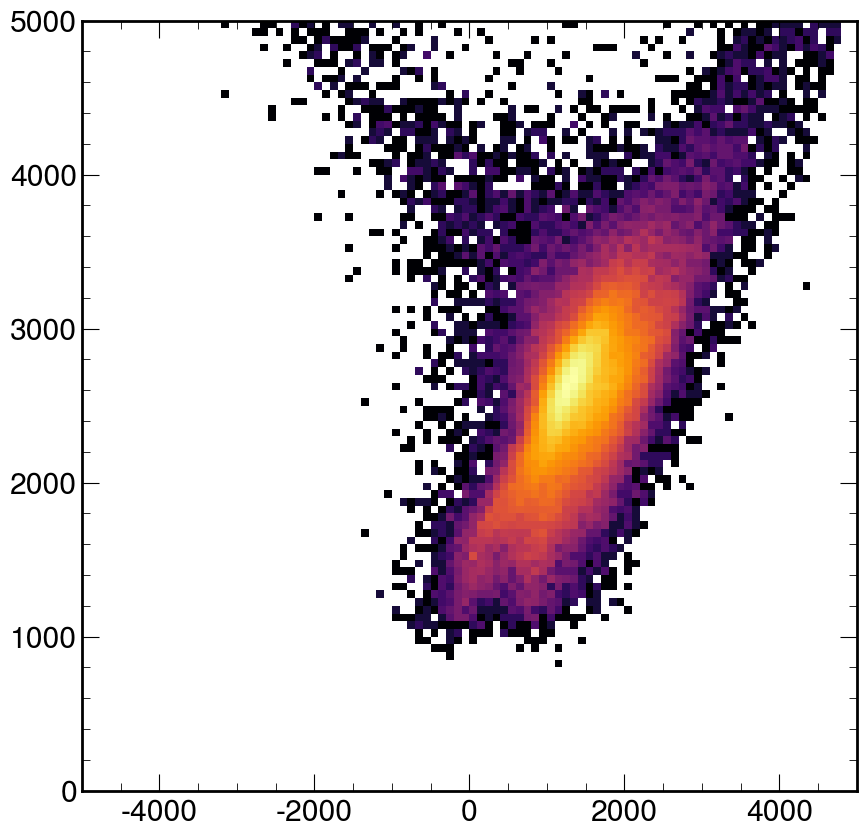

In [279]:
out_notscaled = scaler.inverse_transform(out)

plt.hist2d(out_notscaled[:,0], out_notscaled[:,1],
           bins=100, cmap="inferno", cmin=1, norm=LogNorm(),range=((-5000,5000),(0,5000)) );

In [268]:
out_back = scaler.inverse_transform(out)
x1 = (out_back[:,0] + out_back[:,1])/(6500*2)
x2 = out_back[:,1]/6500  - x1

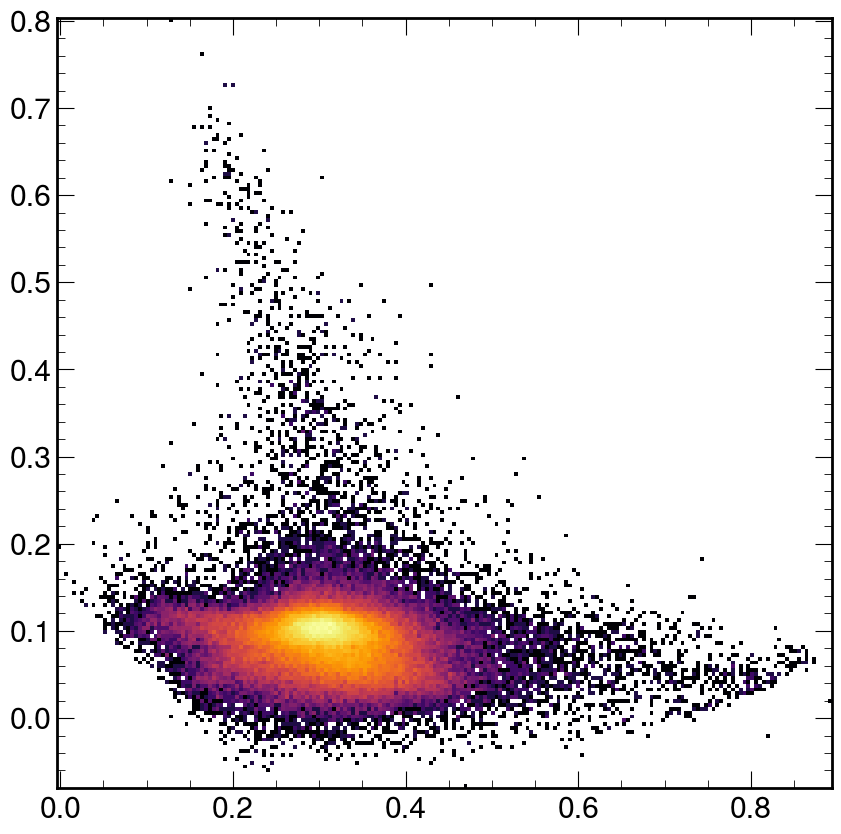

In [280]:
plt.hist2d(x1, x2,
           bins=200, cmap="inferno", cmin=1, norm=LogNorm(), );

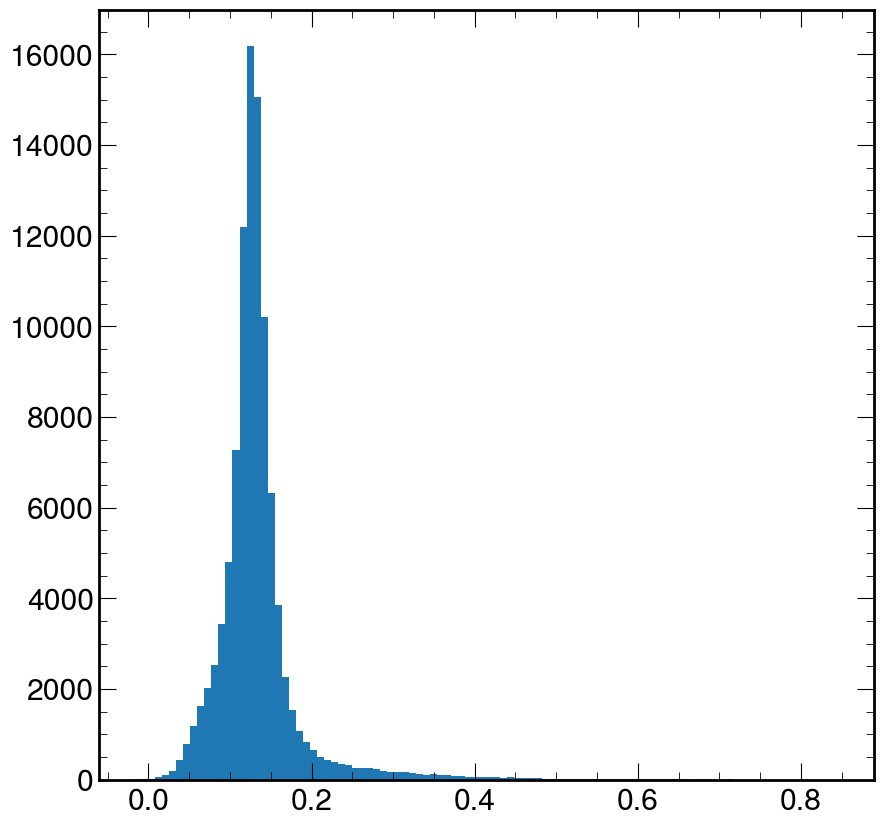

In [144]:
plt.hist(x1, bins=100);

## 